In [7]:
## Getting the data
from influxdb import InfluxDBClient # install via " pip install influxdb "
import pandas as pd

client = InfluxDBClient (host='influxus.itu.dk', port =8086, username ='lsda',
password ='icanonlyread')
client.switch_database ('orkney')

def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index ) # Convert to datetime - index
    return df

# Get the last 90 days of power generation data
generation = client.query (
    "SELECT * FROM Generation where time > now()-90d" # SELECT mean(Total) as Total FROM Generation where time > now()-90d group by time(3h)
    ) # Query written in InfluxQL

# Alternative query to align both datasets (group by time every 3 hours)
generation_1 = client.query (
    "SELECT sum(Total) as Total FROM Generation where time > now()-720d group by time(3h)" 
    )

# Get the last 90 days of weather forecasts with the shortest lead time
wind = client.query(
    "SELECT * FROM MetForecasts where time > now()-720d and time <= now() and Lead_hours = '1'"
    )# Query written in InfluxQL

# generator power every minute
gen_df = get_df(generation)
# generator power grouped by every 3 hours
gen_df_3h = get_df(generation_1)
# wind speed forecast every 3 hours
wind_df = get_df(wind)

In [58]:
# step 1: joining df

df = pd.concat([wind_df, gen_df_3h], axis=1) # one way of concatenating two datasets; 

# df = gen_df_3h.join(wind_df, how="inner")

# Round Speed and Total to two digits
df["Speed"] = df["Speed"].apply(lambda x: float("{:.2f}".format(x)))
df["Total"] = df["Total"].apply(lambda x: float("{:.2f}".format(x)))

df.head()

,Direction,Lead_hours,Source_time,Speed,Total
time,,,,,
2019-10-10 15:00:00+00:00,NaN,NaN,NaN,NaN,3048.56
2019-10-10 18:00:00+00:00,WSW,1,1.570720e+09,4.02,853.41
2019-10-10 21:00:00+00:00,SSE,1,1.570730e+09,4.02,683.81
2019-10-11 00:00:00+00:00,SE,1,1.570741e+09,3.13,943.84
2019-10-11 03:00:00+00:00,E,1,1.570752e+09,7.15,1469.77


In [9]:
# step 2: drop unnecessary cols

df.isnull().sum() # 100 + null values for Total

# df[df.isnull().any(axis=1)] # using axis=1 to select all rows where there is at least one NaN value

# df.dropna(how="any", inplace=True)

df.isnull().sum()

df.drop(["Lead_hours", "Source_time"], axis=1, inplace=True)



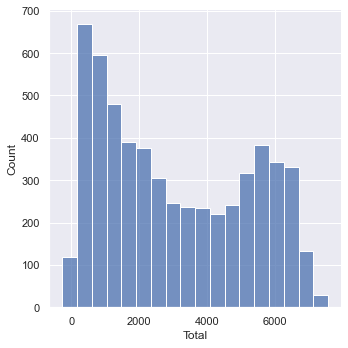

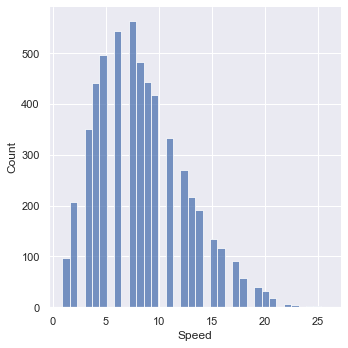

In [143]:
#exploring the data

# example visualize data results
import seaborn as sns
import matplotlib.pylab as plt
sns.set(color_codes=True)
# very useful
# sns.pairplot(df_prepared[["Speed", "Total"]])


# fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# fig.suptitle('Distribution of data points: Total vs. Speed')

# Skewness of Total value
sns.displot(df,x=df["Total"])

# Skewness of Speed value
sns.displot(df, x=df["Speed"])


Unique speed values: 26


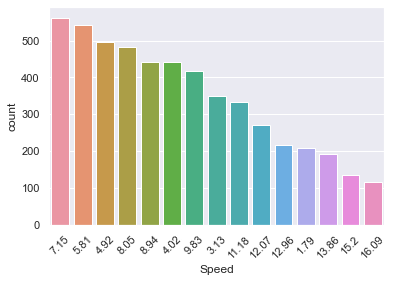

In [90]:
sns.countplot(x="Speed",data=df, order=df.Speed.value_counts().iloc[:15].index)

plt.xticks(rotation=45)

print("Unique speed values: " + str(df['Speed'].nunique()))


In [42]:
# Use preprocessing steps from SciKit for instance
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median', copy=False)),
    ('std_scaler', StandardScaler(copy=False)),
])

cat_pipe = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

# two pipelines combined in the column transformer
full_transform = ColumnTransformer([
    ("num", num_pipe, ["Speed", "Total"]),
    ("cat", cat_pipe, ["Direction"]),
])

full_pipeline = Pipeline([
    ('trf', full_transform)
])

data_prepared = full_pipeline.fit_transform(df)

df_prepared = pd.DataFrame(data_prepared)

df_prepared.rename(columns={ df_prepared.columns[0]: "Speed", df_prepared.columns[1]: "Total"}, inplace=True)

df_prepared

,Speed,Total,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.052446,-0.000137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.014336,-1.032717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.014336,-1.112496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.228090,-0.990179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.266199,-0.742785,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5756,-0.800583,-0.942073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5757,-0.266199,-0.869494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5758,-0.800583,-0.551770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5759,-0.800583,-0.313075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [45]:
# Split data
y_ = df_prepared[["Total"]]

df_prepared.drop(["Total"], axis=1, inplace=True)

#  now split data into training & test
# X_train, X_test, y_train, y_test = train_test_split(df_prepared, y_, test_size=0.2, random_state=42, shuffle=False)


In [46]:
#  now split data into training & test
X_train, X_test, y_train, y_test = train_test_split(df_prepared, y_, test_size=0.33, random_state=42, shuffle=False)

In [48]:
# Polynomial Feature Reg
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

X_

lin_reg = LinearRegression()
lin_reg.fit(X_, y_train)

lin_reg.score(X_test_, y_test)

0.6776750738910738

In [ ]:
# make prediction and combine results
# make prediction based on test data
y_prediction = pd.DataFrame(lin_reg.predict(X_test_))
y_prediction.rename(columns={ y_prediction.columns[0]: "Prediction"}, inplace=True)

# get x test data
X_test_df = pd.DataFrame(X_test_[:,1])
X_test_df.rename(columns={X_test_df.columns[0]: "Speed"}, inplace=True) 

df_prediction_combined = pd.concat([X_test_df, y_prediction], axis=1)

df_prediction_combined

In [ ]:

# one scatterplot showing the test values
sns.scatterplot(X_test["Speed"], y_test["Total"])

# other plot showing the estimated values
sns.regplot(x="Speed", y="Prediction", data=df_prediction_combined,
           order=2, ci=None, scatter_kws={"s": 5}, color="red")


In [ ]:
# just testing around

from matplotlib import pyplot as plt

sns.regplot(x="Speed", y="Total", data=df_prediction_combined,
           order=2, ci=None, scatter_kws={"s": 5})

In [ ]:
# knearest neighbor model
from sklearn.neighbors import KNeighborsRegressor

kneighbor = KNeighborsRegressor(n_neighbors=10) #increased better results

kneighbor.fit(X_, y_train)

kneighbor.score(X_test_, y_test)


In [ ]:
# predict with kneighbor
y_predicted_kn = pd.DataFrame(kneighbor.predict(X_test_))
y_predicted_kn.rename(columns={ y_predicted_kn.columns[0]: "Prediction"}, inplace=True)

df_prediction_combined_kn = pd.concat([X_test_df, y_predicted_kn], axis=1) #X_test_df from above

df_prediction_combined

In [ ]:
# one scatterplot showing the test values
sns.scatterplot(X_test["Speed"], y_test["Total"])

# other plot showing the estimated values
sns.regplot(x="Speed", y="Prediction", data=df_prediction_combined_kn,
           order=2, ci=None, scatter_kws={"s": 5}, color="red")

In [ ]:
# Evaluate with kfold cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from numpy import mean
from numpy import std

#prepare cross validation procedure
cv = KFold(n_splits=5, random_state=None)
# evaluate linear regression model
scores_lin_reg = cross_val_score(lin_reg, df_prepared[["Speed"]], y_, cv=cv)
scores_kneighbors = cross_val_score(kneighbor, df_prepared[["Speed"]], y_, cv=cv)

#report performance
print("Accuracy Linear Regression: %.3f (%.3f)" % (scores_lin_reg.mean(), scores_lin_reg.std()))
print("Accuracy K-nearest neighbors: %.3f (%.3f)" % (scores_kneighbors.mean(), scores_kneighbors.std()))
